# Job salary prediction based on TFIDF and Embedding of job descriptions

In [1]:
import pandas as pd
import numpy as np
import math
import operator
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier

import warnings
warnings.filterwarnings("ignore")

# Read CSV files of training (train_df), validation (valid_df), and test (test_df) set
train_df = pd.read_csv("train.csv")
valid_df = pd.read_csv("valid.csv")
test_df = pd.read_csv("test.csv")

## Data Pre-processing and Exploration

### X train data

In [2]:
# Load TFIDF and Embedding for training set (train_df)
train_tfidf = np.load("train-tfidf.npy")
train_embedding = np.load("train-embeddings.npy")

# TFIDF for labeled and all training set
X_train_tfidf_label = train_tfidf[:8000, :]
X_train_tfidf_all = train_tfidf

# Embedding for labeled and all training set
X_train_embedding_label = train_embedding[:8000, :]
X_train_embedding_all = train_embedding

# Combined TFIDF and Embedding for labeled and all training set
X_train_combined_label = np.concatenate((X_train_tfidf_label, X_train_embedding_label), axis=1)
X_train_combined_all = np.concatenate((X_train_tfidf_all, X_train_embedding_all), axis=1)

# Combined Scaled TFIDF and Embedding for labeled and all training set
# Apply StandardScaler to the entire training set (fit_transform on X_train_tfidf_all)
sc_tfidf_all = StandardScaler()
X_train_tfidf_all_scaled = sc_tfidf_all.fit_transform(X_train_tfidf_all)
sc_embedding_all = StandardScaler()
X_train_embedding_all_scaled = sc_embedding_all.fit_transform(X_train_embedding_all)
X_train_combined_all_scaled = np.concatenate((X_train_tfidf_all_scaled, X_train_embedding_all_scaled), axis=1)

# Setup the lebeled data in training set (first 8000 descriptions)
X_train_tfidf_label_scaled = X_train_tfidf_all_scaled[:8000, :]
X_train_embedding_label_scaled = X_train_embedding_all_scaled[:8000, :]
X_train_combined_label_scaled = np.concatenate((X_train_tfidf_label_scaled, X_train_embedding_label_scaled), axis=1)

### X valid data

In [3]:
# Load TFIDF and Embedding for validation set (valid_df)
valid_tfidf = np.load("valid-tfidf.npy")
valid_embedding = np.load("valid-embeddings.npy")

# TFIDF for validation set
X_valid_tfidf = valid_tfidf

# Embedding for validation set
X_valid_embedding = valid_embedding

# Combined TFIDF and Embedding for validation set
X_valid_combined = np.concatenate((valid_tfidf, valid_embedding), axis=1)

# Combined Scaled TFIDF and Embedding for validation set
# Apply the StandardScaler from training set
X_valid_tfidf_scaled = sc_tfidf_all.transform(X_valid_tfidf)
X_valid_embedding_scaled = sc_embedding_all.transform(X_valid_embedding)
X_valid_combined_scaled = np.concatenate((X_valid_tfidf_scaled, X_valid_embedding_scaled), axis=1)

### X test data

In [4]:
# Load TFIDF and Embedding for test set (test_df)
test_tfidf = np.load("test-tfidf.npy")
test_embedding = np.load("test-embeddings.npy")

# TFIDF for test set
X_test_tfidf = test_tfidf

# Embedding for test set
X_test_embedding = test_embedding

# Combined TFIDF and Embedding for test set
X_test_combined = np.concatenate((test_tfidf, test_embedding), axis=1)

# Combined Scaled TFIDF and Embedding for test set
# Apply the StandardScaler from training set
X_test_tfidf_scaled = sc_tfidf_all.transform(X_test_tfidf)
X_test_embedding_scaled = sc_embedding_all.transform(X_test_embedding)
X_test_combined_scaled = np.concatenate((X_test_tfidf_scaled, X_test_embedding_scaled), axis=1)

### Y data

In [5]:
# salary_bin values in training set (train_df) and validation set (valid_df)
Y_train_salary_bin = train_df["salary_bin"].values[:8000].astype(int)
Y_valid_salary_bin = valid_df["salary_bin"].values.astype(int)

### Mean Expected Salary vs Salary Bin

In [6]:
print("train_df - Data summary of mean_salary for each bin")
print("\n")
print(round(train_df.groupby('salary_bin').agg({'mean_salary':[np.mean, np.std, np.min, np.max, np.size]}), 2))

train_df - Data summary of mean_salary for each bin


           mean_salary                                 
                  mean      std    amin     amax   size
salary_bin                                             
0.0            1828.18   320.48   500.0   2200.0  801.0
1.0            2437.51   127.98  2225.0   2650.0  779.0
2.0            2929.38   142.22  2675.0   3150.0  808.0
3.0            3500.55   187.92  3165.0   3750.0  865.0
4.0            4209.67   224.39  3785.0   4500.0  831.0
5.0            4971.32   195.96  4550.0   5250.0  641.0
6.0            5817.23   276.03  5275.0   6250.0  867.0
7.0            6798.10   265.26  6300.0   7250.0  756.0
8.0            8185.85   595.75  7275.0   9200.0  763.0
9.0           12511.88  3982.62  9234.0  65000.0  889.0


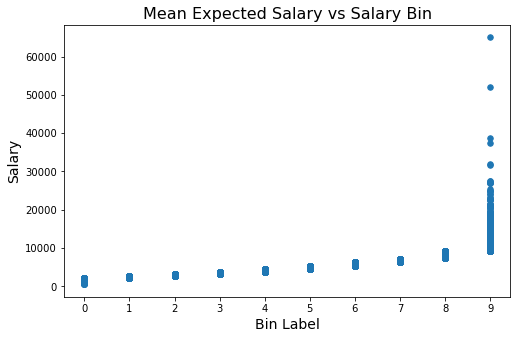

In [7]:
# Salary vs Bin
fig, ax = plt.subplots(figsize=(8,5))
train_df.plot.scatter(x='salary_bin', y='mean_salary', s=30, ax=ax)
ax.set_title('Mean Expected Salary vs Salary Bin', fontsize = 16)
ax.set_ylabel('Salary', fontsize = 14)
ax.set_xlabel('Bin Label', fontsize = 14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

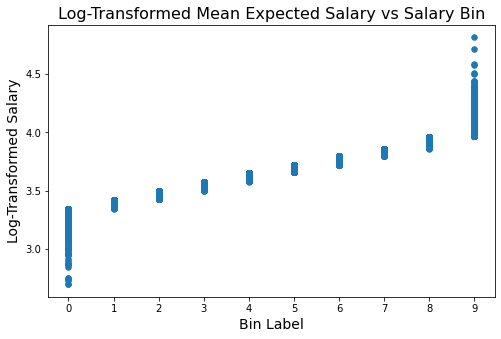

In [8]:
# Log-Transformed Salary vs Bin
train_df_rev = train_df[:8000]

# Calculate Log-Transformed Salary
log_transformed_values = []
for i in range(len(train_df_rev)):
    log_transformed_values.append(math.log10(train_df_rev['mean_salary'].values[i]))

train_df_rev['log_transformed_salary'] = log_transformed_values

fig, ax = plt.subplots(figsize=(8,5))
train_df_rev.plot.scatter(x='salary_bin', y='log_transformed_salary', s=30, ax=ax)
ax.set_title('Log-Transformed Mean Expected Salary vs Salary Bin', fontsize=16)
ax.set_ylabel('Log-Transformed Salary', fontsize=14)
ax.set_xlabel('Bin Label', fontsize=14)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

## Model Training and Hyperparameter Tuning

### Baseline Model (DummyClassifier)

In [9]:
from sklearn.dummy import DummyClassifier

base_acc_tfidf = []
base_acc_embedding = []
base_acc_combined = []
base_acc_combined_scaled = []

for i in range(10):
    
    baseline_model_tfidf = DummyClassifier(strategy="uniform", random_state=i)
    baseline_model_tfidf.fit(X_train_tfidf_label, Y_train_salary_bin)
    baseline_model_embedding = DummyClassifier(strategy="uniform", random_state=i)
    baseline_model_embedding.fit(X_train_embedding_label, Y_train_salary_bin)
    baseline_model_combined = DummyClassifier(strategy="uniform", random_state=i)
    baseline_model_combined.fit(X_train_combined_label, Y_train_salary_bin)
    baseline_model_combined_scaled = DummyClassifier(strategy="uniform", random_state=i)
    baseline_model_combined_scaled.fit(X_train_combined_label_scaled, Y_train_salary_bin)

    base_acc_tfidf.append(baseline_model_tfidf.score(X_valid_tfidf, Y_valid_salary_bin))
    base_acc_embedding.append(baseline_model_embedding.score(X_valid_embedding, Y_valid_salary_bin))
    base_acc_combined.append(baseline_model_combined.score(X_valid_combined, Y_valid_salary_bin))
    base_acc_combined_scaled.append(baseline_model_combined_scaled.score(X_valid_combined_scaled, Y_valid_salary_bin))

print("Baseline Model (TFIDF) accuracy:", round(sum(base_acc_tfidf) / 10.0, 3))
print("Baseline Model (Embedding) accuracy:", round(sum(base_acc_embedding) / 10.0, 3))
print("Baseline Model (combined TFIDF and Embedding) accuracy:", round(sum(base_acc_combined) / 10.0, 3))
print("Baseline Model (combined scaled TFIDF and Embedding) accuracy:", round(sum(base_acc_combined_scaled) / 10.0, 3))

Baseline Model (TFIDF) accuracy: 0.101
Baseline Model (Embedding) accuracy: 0.101
Baseline Model (combined TFIDF and Embedding) accuracy: 0.101
Baseline Model (combined scaled TFIDF and Embedding) accuracy: 0.101


In [10]:
Y_pred_tfidf = baseline_model_tfidf.predict(X_valid_tfidf)
Y_pred_embedding = baseline_model_embedding.predict(X_valid_embedding)
Y_pred_combined = baseline_model_combined.predict(X_valid_combined)
Y_pred_combined_scaled = baseline_model_combined_scaled.predict(X_valid_combined_scaled)

print("Baseline Model (TFIDF)")
print(classification_report(Y_valid_salary_bin, Y_pred_tfidf))

print('\n')

print("Baseline Model (Embedding)")
print(classification_report(Y_valid_salary_bin, Y_pred_embedding))

print('\n')

print("Baseline Model (combined TFIDF and Embedding)")
print(classification_report(Y_valid_salary_bin, Y_pred_combined))

print('\n')

print("Baseline Model (combined scaled TFIDF and Embedding)")
print(classification_report(Y_valid_salary_bin, Y_pred_combined_scaled))

Baseline Model (TFIDF)
              precision    recall  f1-score   support

           0       0.09      0.08      0.08       180
           1       0.06      0.07      0.06       142
           2       0.15      0.14      0.14       181
           3       0.10      0.09      0.10       190
           4       0.09      0.08      0.08       201
           5       0.13      0.15      0.14       150
           6       0.12      0.12      0.12       178
           7       0.12      0.13      0.12       171
           8       0.08      0.08      0.08       171
           9       0.12      0.12      0.12       173

    accuracy                           0.11      1737
   macro avg       0.11      0.11      0.11      1737
weighted avg       0.11      0.11      0.11      1737



Baseline Model (Embedding)
              precision    recall  f1-score   support

           0       0.09      0.08      0.08       180
           1       0.06      0.07      0.06       142
           2       0.15   

### Multinomial Naïve Bayes

For Multinomial Naïve Bayes, the hyperparameter to be tuned is:
- **alpha:** additive Laplace smoothing parameter

#### TFIDF

In [11]:
from sklearn.naive_bayes import MultinomialNB

parameters = [
    {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 20]
    }
]

# Search for the best parameters
model = MultinomialNB()
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_tfidf_label, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'alpha': 0.5}

In [12]:
# Output the hyperparameter tuning results
gs_res = {
    'alpha': [gs.cv_results_['params'][i]['alpha'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

mnb_df = pd.DataFrame(gs_res)
mnb_df

,alpha,runtime,mean test score
0,0.0,0.023929,0.240375
1,0.1,0.020066,0.240875
2,0.2,0.019727,0.240500
3,0.3,0.018719,0.241250
4,0.4,0.018125,0.242000
5,0.5,0.018351,0.242625
6,0.6,0.018351,0.242375
7,0.7,0.018131,0.241625
8,0.8,0.019335,0.240750
9,0.9,0.019929,0.240000


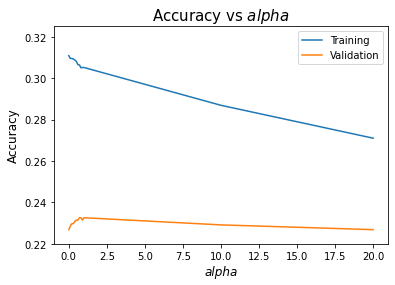

In [13]:
train_acc = []
valid_acc = []

for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 20]:
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train_tfidf_label,Y_train_salary_bin)
    train_acc.append(clf.score(X_train_tfidf_label, Y_train_salary_bin))
    valid_acc.append(clf.score(X_valid_tfidf, Y_valid_salary_bin))
    
figure(figsize=(6,4))
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 20]
  
# Plot Training and Validation accuracy
plt.plot(x, train_acc, label = "Training")
plt.plot(x, valid_acc, label = "Validation")

plt.title('Accuracy vs $\it{alpha}$', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('alpha', fontsize=12, style='italic')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.ylim(0.22,0.325)
plt.show()

In [14]:
clf = MultinomialNB(alpha=0.5)
clf.fit(X_train_tfidf_label, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_tfidf, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.231


In [15]:
Y_pred = clf.predict(X_valid_tfidf)

print("MultinomialNB (TFIDF)")
print(classification_report(Y_valid_salary_bin, Y_pred))

MultinomialNB (TFIDF)
              precision    recall  f1-score   support

           0       0.40      0.63      0.49       180
           1       0.15      0.16      0.16       142
           2       0.21      0.15      0.18       181
           3       0.18      0.17      0.17       190
           4       0.21      0.12      0.15       201
           5       0.11      0.01      0.01       150
           6       0.17      0.22      0.19       178
           7       0.20      0.20      0.20       171
           8       0.19      0.09      0.13       171
           9       0.23      0.54      0.33       173

    accuracy                           0.23      1737
   macro avg       0.21      0.23      0.20      1737
weighted avg       0.21      0.23      0.20      1737



In [16]:
# The value each feature's coefficient is a measure of its importance.Use "clf.coef_" to find the coefficient value.  
# The larger the value, the more likely that feature is associated with the target class.
# Search for the Top 10 words in "tfidf_words.csv"

df_tfidf_words = pd.read_csv('tfidf_words.csv', header=None)
tfidf_words = df_tfidf_words[0].values

# Zip the coefficient with words, and sort the values in ascending order
coefs_with_words = sorted(zip(clf.coef_[0], tfidf_words), reverse=True)

df = pd.DataFrame(columns = ['coef', 'word'])
coef = []
word = []
for i in range(10):
    coef.append(coefs_with_words[:10][i][0])
    word.append(coefs_with_words[:10][i][1])

df['coef'] = coef
df['word'] = word
df

,coef,word
0,-4.129980,duties
1,-4.365747,assist
2,-4.491864,customer
3,-4.526898,customers
4,-4.567137,ensure
5,-4.631731,sales
6,-4.656500,perform
7,-4.679107,work
8,-4.732253,service
9,-4.752893,assigned


### K-Nearest Neighbors

Initially, investigate the effect of distance metrics on the model, including:
- manhattan
- euclidean
- cosine

In [17]:
from sklearn.neighbors import KNeighborsClassifier

parameters = [
    {'metric': ['manhattan', 'euclidean', 'cosine']
    }
]

# Search for the best parameters
model = KNeighborsClassifier()
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_tfidf_label, Y_train_salary_bin)

# Output the hyperparameter tuning results
gs_res = {
    'metric': [gs.cv_results_['params'][i]['metric'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

knn_tfidf_df = pd.DataFrame(gs_res)
knn_tfidf_df

,metric,runtime,mean test score
0,manhattan,4.519090,0.125250
1,euclidean,0.317059,0.159250
2,cosine,0.305384,0.201125


In [18]:
from sklearn.neighbors import KNeighborsClassifier

parameters = [
    {'metric': ['manhattan', 'euclidean', 'cosine']
    }
]

# Search for the best parameters
model = KNeighborsClassifier()
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_embedding_label, Y_train_salary_bin)

# Output the hyperparameter tuning results
gs_res = {
    'metric': [gs.cv_results_['params'][i]['metric'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

knn_embedding_df = pd.DataFrame(gs_res)
knn_embedding_df

,metric,runtime,mean test score
0,manhattan,3.677490,0.2075
1,euclidean,0.354647,0.2090
2,cosine,0.238809,0.2090


The distance metric is set to **'cosine'** and the hyperparameter to be tuned is:
- **n_neighbors:** number of nearest neighbors to be considered

#### TFIDF

In [19]:
parameters = [
    {'n_neighbors': list(range(5,100))
    }
]

# Search for the best parameters
model = KNeighborsClassifier(metric='cosine')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_tfidf_label, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'n_neighbors': 65}

In [20]:
# Output the hyperparameter tuning results
gs_res = {
    'n_neighbors': [gs.cv_results_['params'][i]['n_neighbors'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

knn1_df = pd.DataFrame(gs_res)
knn1_df

,n_neighbors,runtime,mean test score
0,5,0.310687,0.201125
1,6,0.313069,0.203125
2,7,0.308582,0.204625
3,8,0.314319,0.207375
4,9,0.306897,0.207375
...,...,...,...
90,95,0.342680,0.229000
91,96,0.330181,0.228375
92,97,0.321310,0.228375
93,98,0.357477,0.228250


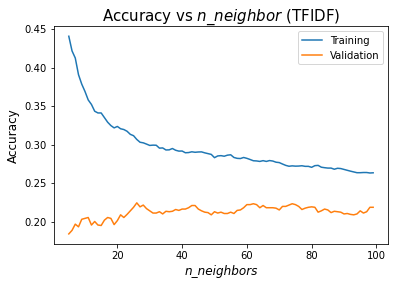

In [21]:
from sklearn.neighbors import KNeighborsClassifier

train_acc = []
valid_acc = []

for i in list(range(5,100)):
    clf = KNeighborsClassifier(metric='cosine', n_neighbors=i)
    clf.fit(X_train_tfidf_label,Y_train_salary_bin)
    train_acc.append(clf.score(X_train_tfidf_label, Y_train_salary_bin))
    valid_acc.append(clf.score(X_valid_tfidf, Y_valid_salary_bin))
    
figure(figsize=(6,4))
x = list(range(5,100))
  
# Plot Training and Validation accuracy
plt.plot(x, train_acc, label = "Training")
plt.plot(x, valid_acc, label = "Validation")

plt.title('Accuracy vs $\it{n\_neighbor}$ (TFIDF)', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('n_neighbors', fontsize=12, style='italic')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [22]:
clf = KNeighborsClassifier(metric='cosine', n_neighbors=65)
clf.fit(X_train_tfidf_label, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_tfidf, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.221


#### Embedding

In [23]:
parameters = [
    {'n_neighbors': list(range(5,100))
    }
]

# Search for the best parameters
model = KNeighborsClassifier(metric='cosine')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_embedding_label, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'n_neighbors': 90}

In [24]:
# Output the hyperparameter tuning results
gs_res = {
    'n_neighbors': [gs.cv_results_['params'][i]['n_neighbors'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

knn2_df = pd.DataFrame(gs_res)
knn2_df

,n_neighbors,runtime,mean test score
0,5,0.248943,0.209000
1,6,0.237758,0.209375
2,7,0.225206,0.214625
3,8,0.233211,0.216125
4,9,0.228984,0.218375
...,...,...,...
90,95,0.233763,0.237250
91,96,0.237757,0.237125
92,97,0.247654,0.237750
93,98,0.240657,0.237875


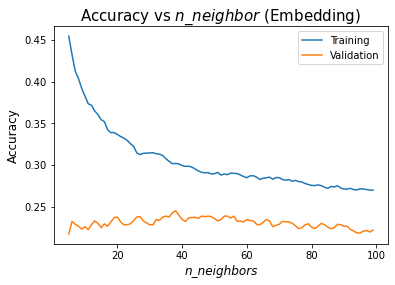

In [25]:
train_acc = []
valid_acc = []

for i in list(range(5,100)):
    clf = KNeighborsClassifier(metric='cosine', n_neighbors=i)
    clf.fit(X_train_embedding_label,Y_train_salary_bin)
    train_acc.append(clf.score(X_train_embedding_label, Y_train_salary_bin))
    valid_acc.append(clf.score(X_valid_embedding, Y_valid_salary_bin))
                     
figure(figsize=(6,4))
x = list(range(5,100))
  
# Plot Training and Validation accuracy
plt.plot(x, train_acc, label = "Training")
plt.plot(x, valid_acc, label = "Validation")

plt.title('Accuracy vs $\it{n\_neighbor}$ (Embedding)', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('n_neighbors', fontsize=12, style='italic')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [26]:
clf = KNeighborsClassifier(metric='cosine', n_neighbors=90)
clf.fit(X_train_embedding_label, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_embedding, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.227


#### Combined

In [27]:
parameters = [
    {'n_neighbors': list(range(5,100))
    }
]

# Search for the best parameters
model = KNeighborsClassifier(metric='cosine')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_combined_label, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'n_neighbors': 67}

In [28]:
# Output the hyperparameter tuning results
gs_res = {
    'n_neighbors': [gs.cv_results_['params'][i]['n_neighbors'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

knn3_df = pd.DataFrame(gs_res)
knn3_df

,n_neighbors,runtime,mean test score
0,5,0.399310,0.212375
1,6,0.398072,0.216625
2,7,0.391559,0.214375
3,8,0.395589,0.222000
4,9,0.389611,0.222125
...,...,...,...
90,95,0.431180,0.238000
91,96,0.426460,0.237750
92,97,0.433050,0.239500
93,98,0.427938,0.241000


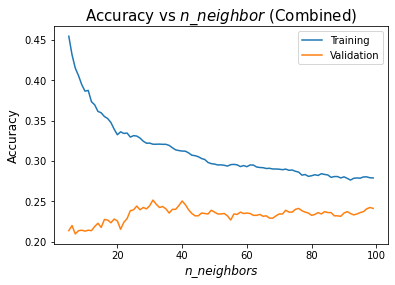

In [29]:
train_acc = []
valid_acc = []

for i in list(range(5,100)):
    clf = KNeighborsClassifier(metric='cosine', n_neighbors=i)
    clf.fit(X_train_combined_label,Y_train_salary_bin)
    train_acc.append(clf.score(X_train_combined_label, Y_train_salary_bin))
    valid_acc.append(clf.score(X_valid_combined, Y_valid_salary_bin))
                     
figure(figsize=(6,4))
x = list(range(5,100))
  
# Plot Training and Validation accuracy
plt.plot(x, train_acc, label = "Training")
plt.plot(x, valid_acc, label = "Validation")

plt.title('Accuracy vs $\it{n\_neighbor}$ (Combined)', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('n_neighbors', fontsize=12, style='italic')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [30]:
clf = KNeighborsClassifier(metric='cosine', n_neighbors=67)
clf.fit(X_train_combined_label, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_combined, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.229


#### Combined Scaled

In [31]:
parameters = [
    {'n_neighbors': list(range(5,100)),
    }
]

# Search for the best parameters
model = KNeighborsClassifier(metric='cosine')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_combined_label_scaled, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'n_neighbors': 51}

In [32]:
# Output the hyperparameter tuning results
gs_res = {
    'n_neighbors': [gs.cv_results_['params'][i]['n_neighbors'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

knn4_df = pd.DataFrame(gs_res)
knn4_df

,n_neighbors,runtime,mean test score
0,5,0.415932,0.215625
1,6,0.426035,0.217250
2,7,0.466485,0.222875
3,8,0.437417,0.223750
4,9,0.439590,0.223875
...,...,...,...
90,95,0.436071,0.246250
91,96,0.434165,0.247625
92,97,0.436034,0.249500
93,98,0.439034,0.249625


In [41]:
# Retrieve runtime when 'n_neighbors' = 51
knn4_df[46:47]

,n_neighbors,runtime,mean test score
46,51,0.489736,0.25525


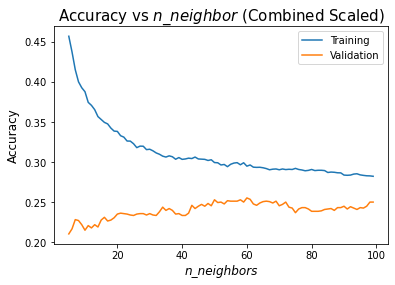

In [33]:
train_acc = []
valid_acc = []

for i in list(range(5,100)):
    clf = KNeighborsClassifier(metric='cosine', n_neighbors=i)
    clf.fit(X_train_combined_label_scaled,Y_train_salary_bin)
    train_acc.append(clf.score(X_train_combined_label_scaled, Y_train_salary_bin))
    valid_acc.append(clf.score(X_valid_combined_scaled, Y_valid_salary_bin))
                     
figure(figsize=(6, 4))
x = list(range(5,100))
  
# Plot Training and Validation accuracy
plt.plot(x, train_acc, label = "Training")
plt.plot(x, valid_acc, label = "Validation")

plt.title('Accuracy vs $\it{n\_neighbor}$ (Combined Scaled)', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('n_neighbors', fontsize=12, style='italic')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [36]:
clf = KNeighborsClassifier(metric='cosine', n_neighbors=51)
clf.fit(X_train_combined_label_scaled, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_combined_scaled, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.25


In [37]:
Y_pred = clf.predict(X_valid_combined_scaled)

print("KNeighborsClassifier (Combined Scaled)")
print(classification_report(Y_valid_salary_bin, Y_pred))

KNeighborsClassifier (Combined Scaled)
              precision    recall  f1-score   support

           0       0.38      0.63      0.47       180
           1       0.22      0.27      0.25       142
           2       0.17      0.17      0.17       181
           3       0.21      0.18      0.20       190
           4       0.20      0.13      0.16       201
           5       0.20      0.09      0.12       150
           6       0.18      0.17      0.18       178
           7       0.24      0.20      0.22       171
           8       0.24      0.15      0.18       171
           9       0.29      0.50      0.36       173

    accuracy                           0.25      1737
   macro avg       0.23      0.25      0.23      1737
weighted avg       0.23      0.25      0.23      1737



### Random Forest

For random forest, the hyperparameters to be tuned include:
- **n_estimators:** the number of trees
- **max_depth:** the maximum depth of the tree

#### TFIDF

In [35]:
from sklearn.ensemble import RandomForestClassifier

parameters = [
    {'n_estimators': [100, 200, 300, 400, 500],
     'max_depth': [10, 20, 30, 40, 50],
    }
]

# Search for the best parameters
model = RandomForestClassifier(criterion='entropy')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_tfidf_label, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'max_depth': 30, 'n_estimators': 500}

In [36]:
# Output the hyperparameter tuning results
gs_res = {
    'n_estimators': [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))],
    'max_depth': [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

rf1_df = pd.DataFrame(gs_res)
rf1_df

,n_estimators,max_depth,runtime,mean test score
0,100,10,3.011891,0.238000
1,200,10,6.305823,0.235000
2,300,10,9.357577,0.239125
3,400,10,12.513234,0.241500
4,500,10,15.614153,0.241375
5,100,20,4.991513,0.245875
6,200,20,9.589521,0.249625
7,300,20,14.274159,0.250750
8,400,20,19.177044,0.253250
9,500,20,23.883723,0.251375


In [37]:
clf = RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=500)
clf.fit(X_train_tfidf_label, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_tfidf, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.253


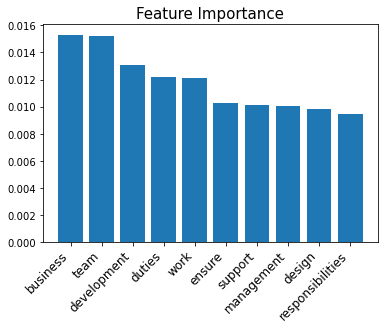

In [38]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# Feature importances are provided by the fitted attribute feature_importances_ 
# and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
# Search for the Top 10 words in "tfidf_words.csv"

# Calculate feature importances
importances = clf.feature_importances_

# Sort feature importances in descending order and take the first 20 features
indices = np.argsort(importances)[::-1][:10]

df_tfidf_words = pd.read_csv('tfidf_words.csv', header=None)
tfidf_words = df_tfidf_words[0].values

# Rearrange feature names so they match the sorted feature importances
features = [tfidf_words[i] for i in indices]

# Create a plot
plt.figure()
plt.bar(range(10), importances[indices])
plt.xticks(range(10), features, rotation=45, ha='right', fontsize=12)
plt.title("Feature Importance", fontsize=15)
plt.show()

#### Embedding

In [40]:
parameters = [
    {'n_estimators': [100, 200, 300, 400, 500],
     'max_depth': [10, 20, 30, 40, 50],
    }
]

# Search for the best parameters
model = RandomForestClassifier(criterion='entropy')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_embedding_label, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'max_depth': 20, 'n_estimators': 400}

In [41]:
# Output the hyperparameter tuning results
gs_res = {
    'n_estimators': [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))],
    'max_depth': [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

rf2_df = pd.DataFrame(gs_res)
rf2_df

,n_estimators,max_depth,runtime,mean test score
0,100,10,25.583026,0.232000
1,200,10,48.128862,0.240000
2,300,10,71.891213,0.251625
3,400,10,96.664573,0.253250
4,500,10,121.265853,0.248875
5,100,20,27.374081,0.240250
6,200,20,55.031476,0.244375
7,300,20,82.289598,0.246375
8,400,20,108.702344,0.257000
9,500,20,135.546203,0.253250


In [36]:
clf = RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=400)
clf.fit(X_train_embedding_label, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_embedding, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.251


#### Combined

In [43]:
parameters = [
    {'n_estimators': [100, 200, 300, 400, 500],
     'max_depth': [10, 20, 30, 40, 50],
    }
]

# Search for the best parameters
model = RandomForestClassifier(criterion='entropy')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_combined_label, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'max_depth': 30, 'n_estimators': 500}

In [44]:
# Output the hyperparameter tuning results
gs_res = {
    'n_estimators': [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))],
    'max_depth': [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

rf3_df = pd.DataFrame(gs_res)
rf3_df

,n_estimators,max_depth,runtime,mean test score
0,100,10,18.434633,0.242125
1,200,10,36.899385,0.249000
2,300,10,55.299720,0.249500
3,400,10,74.131368,0.254250
4,500,10,92.225049,0.255875
5,100,20,22.025398,0.241375
6,200,20,43.970030,0.251125
7,300,20,65.428067,0.253625
8,400,20,85.427750,0.257500
9,500,20,105.245837,0.251375


In [45]:
clf = RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=500)
clf.fit(X_train_combined_label, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_combined, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.257


#### Combined Scaled

In [46]:
parameters = [
    {'n_estimators': [100, 200, 300, 400, 500],
     'max_depth': [10, 20, 30, 40, 50],
    }
]

# Search for the best parameters
model = RandomForestClassifier(criterion='entropy')
gs = GridSearchCV(model, parameters, scoring='accuracy')
gs.fit(X_train_combined_label_scaled, Y_train_salary_bin)

# Best parameters
gs.best_params_

{'max_depth': 40, 'n_estimators': 400}

In [47]:
# Output the hyperparameter tuning results
gs_res = {
    'n_estimators': [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))],
    'max_depth': [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))],
    'runtime': gs.cv_results_['mean_fit_time'] + gs.cv_results_['mean_score_time'],
    'mean test score': gs.cv_results_['mean_test_score']
}

rf4_df = pd.DataFrame(gs_res)
rf4_df

,n_estimators,max_depth,runtime,mean test score
0,100,10,18.498914,0.241125
1,200,10,36.855275,0.253000
2,300,10,55.612798,0.251750
3,400,10,74.807170,0.255750
4,500,10,93.146283,0.253375
5,100,20,21.910752,0.237625
6,200,20,44.307864,0.247000
7,300,20,68.936609,0.249375
8,400,20,88.294278,0.255125
9,500,20,110.615424,0.254750


In [62]:
clf = RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=400)
clf.fit(X_train_combined_label_scaled, Y_train_salary_bin)
print("Accuracy for Validation Set: {}".format(round(clf.score(X_valid_combined_scaled, Y_valid_salary_bin), 3)))

Accuracy for Validation Set: 0.263


In [63]:
Y_pred = clf.predict(X_valid_combined_scaled)

print("RandomForestClassifier (Combined Scaled)")
print(classification_report(Y_valid_salary_bin, Y_pred))

RandomForestClassifier (Combined Scaled)
              precision    recall  f1-score   support

           0       0.38      0.67      0.48       180
           1       0.23      0.23      0.23       142
           2       0.20      0.15      0.17       181
           3       0.18      0.18      0.18       190
           4       0.21      0.16      0.18       201
           5       0.24      0.04      0.07       150
           6       0.21      0.26      0.23       178
           7       0.27      0.13      0.18       171
           8       0.32      0.18      0.23       171
           9       0.28      0.60      0.39       173

    accuracy                           0.26      1737
   macro avg       0.25      0.26      0.23      1737
weighted avg       0.25      0.26      0.24      1737



## Research Question 1: Semi-supervised Learning

### threshold

#### Multinomial Naïve Bayes

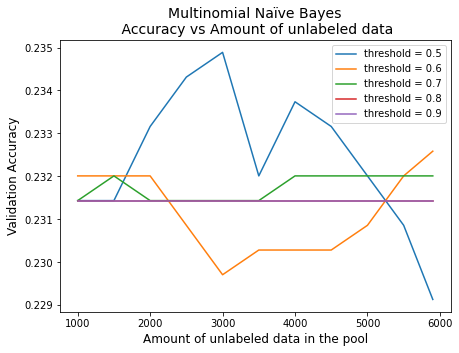

In [73]:
from sklearn.semi_supervised import SelfTrainingClassifier

Valid_Acc = []

for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    clf = MultinomialNB(alpha=0.5)
    self_training_clf = SelfTrainingClassifier(clf, criterion='threshold', threshold=threshold)

    Y_train_salary_bin = train_df["salary_bin"].values.astype(int)
    # Unlabeled samples should have the label -1
    Y_train_salary_bin[8000:] = -1

    train_acc = []
    valid_acc = []

    for i in [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]:
        self_training_clf.fit(X_train_tfidf_all[:i], Y_train_salary_bin[:i])
        train_acc.append(self_training_clf.score(X_train_tfidf_all[:i], Y_train_salary_bin[:i]))
        valid_acc.append(self_training_clf.score(X_valid_tfidf, Y_valid_salary_bin))
        
    Valid_Acc.append(valid_acc)

figure(figsize=(7, 5))
x = [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]
x = [i - 8000 for i in x]

# Plot Validation accuracy
plt.plot(x, Valid_Acc[0], label = "threshold = 0.5")
plt.plot(x, Valid_Acc[1], label = "threshold = 0.6")
plt.plot(x, Valid_Acc[2], label = "threshold = 0.7")
plt.plot(x, Valid_Acc[3], label = "threshold = 0.8")
plt.plot(x, Valid_Acc[4], label = "threshold = 0.9")

plt.title('Multinomial Naïve Bayes\n Accuracy vs Amount of unlabeled data', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Amount of unlabeled data in the pool', fontsize=12)
plt.legend(loc='upper right')
plt.show()

df = pd.DataFrame(columns = ['Amount of unlabeled data', 'threshold=0.5', 'threshold=0.6', 'threshold=0.7', 'threshold=0.8', 'threshold=0.9'])
df['Amount of unlabeled data'] = x
df['threshold=0.5'] = Valid_Acc[0]
df['threshold=0.6'] = Valid_Acc[1]
df['threshold=0.7'] = Valid_Acc[2]
df['threshold=0.8'] = Valid_Acc[3]
df['threshold=0.9'] = Valid_Acc[4]
df.to_excel('mnb_th.xlsx')

In [74]:
df

,Amount of unlabeled data,threshold=0.5,threshold=0.6,threshold=0.7,threshold=0.8,threshold=0.9
0,1000,0.231434,0.232009,0.231434,0.231434,0.231434
1,1500,0.231434,0.232009,0.232009,0.231434,0.231434
2,2000,0.233161,0.232009,0.231434,0.231434,0.231434
3,2500,0.234312,0.230858,0.231434,0.231434,0.231434
4,3000,0.234888,0.229706,0.231434,0.231434,0.231434
5,3500,0.232009,0.230282,0.231434,0.231434,0.231434
6,4000,0.233736,0.230282,0.232009,0.231434,0.231434
7,4500,0.233161,0.230282,0.232009,0.231434,0.231434
8,5000,0.232009,0.230858,0.232009,0.231434,0.231434
9,5500,0.230858,0.232009,0.232009,0.231434,0.231434


#### K-Nearest Neighbors

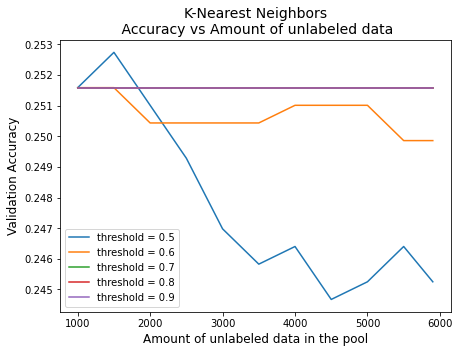

In [75]:
from sklearn.semi_supervised import SelfTrainingClassifier

Valid_Acc = []

for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    clf = KNeighborsClassifier(metric='cosine', n_neighbors=45)
    self_training_clf = SelfTrainingClassifier(clf, criterion='threshold', threshold=threshold)

    Y_train_salary_bin = train_df["salary_bin"].values.astype(int)
    # Unlabeled samples should have the label -1
    Y_train_salary_bin[8000:] = -1

    train_acc = []
    valid_acc = []

    for i in [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]:
        self_training_clf.fit(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i])
        train_acc.append(self_training_clf.score(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i]))
        valid_acc.append(self_training_clf.score(X_valid_combined_scaled, Y_valid_salary_bin))
        
    Valid_Acc.append(valid_acc)

figure(figsize=(7, 5))
x = [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]
x = [i - 8000 for i in x]

# Plot Validation accuracy
plt.plot(x, Valid_Acc[0], label = "threshold = 0.5")
plt.plot(x, Valid_Acc[1], label = "threshold = 0.6")
plt.plot(x, Valid_Acc[2], label = "threshold = 0.7")
plt.plot(x, Valid_Acc[3], label = "threshold = 0.8")
plt.plot(x, Valid_Acc[4], label = "threshold = 0.9")

plt.title('K-Nearest Neighbors\n Accuracy vs Amount of unlabeled data', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Amount of unlabeled data in the pool', fontsize=12)
plt.legend(loc='lower left')
plt.show()

df = pd.DataFrame(columns = ['Amount of unlabeled data', 'threshold=0.5', 'threshold=0.6', 'threshold=0.7', 'threshold=0.8', 'threshold=0.9'])
df['Amount of unlabeled data'] = x
df['threshold=0.5'] = Valid_Acc[0]
df['threshold=0.6'] = Valid_Acc[1]
df['threshold=0.7'] = Valid_Acc[2]
df['threshold=0.8'] = Valid_Acc[3]
df['threshold=0.9'] = Valid_Acc[4]
df.to_excel('knn_th.xlsx')

In [76]:
df

,Amount of unlabeled data,threshold=0.5,threshold=0.6,threshold=0.7,threshold=0.8,threshold=0.9
0,1000,0.251583,0.251583,0.251583,0.251583,0.251583
1,1500,0.252735,0.251583,0.251583,0.251583,0.251583
2,2000,0.251007,0.250432,0.251583,0.251583,0.251583
3,2500,0.249280,0.250432,0.251583,0.251583,0.251583
4,3000,0.246978,0.250432,0.251583,0.251583,0.251583
5,3500,0.245826,0.250432,0.251583,0.251583,0.251583
6,4000,0.246402,0.251007,0.251583,0.251583,0.251583
7,4500,0.244675,0.251007,0.251583,0.251583,0.251583
8,5000,0.245250,0.251007,0.251583,0.251583,0.251583
9,5500,0.246402,0.249856,0.251583,0.251583,0.251583


#### Random Forest

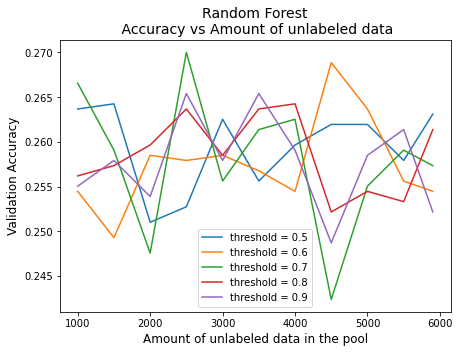

In [77]:
from sklearn.semi_supervised import SelfTrainingClassifier

Valid_Acc = []

for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    clf = RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=400)
    self_training_clf = SelfTrainingClassifier(clf, criterion='threshold', threshold=threshold)

    Y_train_salary_bin = train_df["salary_bin"].values.astype(int)
    # Unlabeled samples should have the label -1
    Y_train_salary_bin[8000:] = -1

    train_acc = []
    valid_acc = []

    for i in [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]:
        self_training_clf.fit(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i])
        train_acc.append(self_training_clf.score(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i]))
        valid_acc.append(self_training_clf.score(X_valid_combined_scaled, Y_valid_salary_bin))

    Valid_Acc.append(valid_acc)

figure(figsize=(7, 5))
x = [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]
x = [i - 8000 for i in x]

# Plot Validation accuracy
plt.plot(x, Valid_Acc[0], label = "threshold = 0.5")
plt.plot(x, Valid_Acc[1], label = "threshold = 0.6")
plt.plot(x, Valid_Acc[2], label = "threshold = 0.7")
plt.plot(x, Valid_Acc[3], label = "threshold = 0.8")
plt.plot(x, Valid_Acc[4], label = "threshold = 0.9")

plt.title('Random Forest\n Accuracy vs Amount of unlabeled data', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Amount of unlabeled data in the pool', fontsize=12)
plt.legend()
plt.show()

df = pd.DataFrame(columns = ['Amount of unlabeled data', 'threshold=0.5', 'threshold=0.6', 'threshold=0.7', 'threshold=0.8', 'threshold=0.9'])
df['Amount of unlabeled data'] = x
df['threshold=0.5'] = Valid_Acc[0]
df['threshold=0.6'] = Valid_Acc[1]
df['threshold=0.7'] = Valid_Acc[2]
df['threshold=0.8'] = Valid_Acc[3]
df['threshold=0.9'] = Valid_Acc[4]
df.to_excel('rf_th.xlsx')

In [78]:
df

,Amount of unlabeled data,threshold=0.5,threshold=0.6,threshold=0.7,threshold=0.8,threshold=0.9
0,1000,0.263673,0.254462,0.266552,0.256189,0.255037
1,1500,0.264249,0.249280,0.259067,0.257340,0.257916
2,2000,0.251007,0.258492,0.247553,0.259643,0.253886
3,2500,0.252735,0.257916,0.270006,0.263673,0.265400
4,3000,0.262522,0.258492,0.255613,0.258492,0.257916
5,3500,0.255613,0.256765,0.261370,0.263673,0.265400
6,4000,0.259643,0.254462,0.262522,0.264249,0.259067
7,4500,0.261946,0.268854,0.242372,0.252159,0.248705
8,5000,0.261946,0.263673,0.255037,0.254462,0.258492
9,5500,0.257916,0.255613,0.259067,0.253310,0.261370


In [132]:
from sklearn.semi_supervised import SelfTrainingClassifier

clf = RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=400)
self_training_clf = SelfTrainingClassifier(clf, criterion='threshold', threshold=0.7)

Y_train_salary_bin = train_df["salary_bin"].values.astype(int)
# Unlabeled samples should have the label -1
Y_train_salary_bin[8000:] = -1

self_training_clf.fit(X_train_tfidf_all[:10500], Y_train_salary_bin[:10500])

Y_pred = self_training_clf.predict(X_valid_tfidf)

print("Semi-supervised Learning (Random Forest)")
print(classification_report(Y_valid_salary_bin, Y_pred))

Semi-supervised Learning (Random Forest)
              precision    recall  f1-score   support

           0       0.36      0.72      0.48       180
           1       0.20      0.15      0.17       142
           2       0.23      0.18      0.20       181
           3       0.21      0.19      0.20       190
           4       0.25      0.14      0.18       201
           5       0.14      0.03      0.04       150
           6       0.22      0.26      0.24       178
           7       0.26      0.16      0.20       171
           8       0.35      0.16      0.22       171
           9       0.26      0.62      0.37       173

    accuracy                           0.27      1737
   macro avg       0.25      0.26      0.23      1737
weighted avg       0.25      0.27      0.23      1737



##### Kaggle submission

In [133]:
# Retrieve job_id in test_df
test_prediction = test_df.copy()
test_prediction.drop(columns = ['requirements_and_role', 'gender_code'], inplace=True)

# Predict the test salary using Combined Scaled input features
Y_pred = self_training_clf.predict(X_test_combined_scaled)
test_prediction['salary_bin'] = Y_pred
# Submit the results to participate in Kaggle in-class competition
test_prediction.to_csv('test_prediction.csv')
test_prediction.head()

,job_id,salary_bin
0,JOB-2019-0016087,0
1,JOB-2019-0008055,9
2,JOB-2019-0001658,6
3,JOB-2019-0016777,8
4,JOB-2019-0017600,7


### k_best

#### Multinomial Naïve Bayes

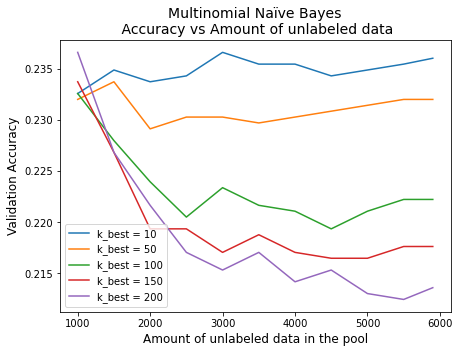

In [9]:
from sklearn.semi_supervised import SelfTrainingClassifier

Valid_Acc = []

for k_best in [10, 50, 100, 150, 200]:
    clf = MultinomialNB(alpha=0.5)
    self_training_clf = SelfTrainingClassifier(clf, criterion='k_best', k_best=k_best)

    Y_train_salary_bin = train_df["salary_bin"].values.astype(int)
    # Unlabeled samples should have the label -1
    Y_train_salary_bin[8000:] = -1

    train_acc = []
    valid_acc = []

    for i in [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]:
        self_training_clf.fit(X_train_tfidf_all[:i], Y_train_salary_bin[:i])
        train_acc.append(self_training_clf.score(X_train_tfidf_all[:i], Y_train_salary_bin[:i]))
        valid_acc.append(self_training_clf.score(X_valid_tfidf, Y_valid_salary_bin))

    Valid_Acc.append(valid_acc)

figure(figsize=(7, 5))
x = [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]
x = [i - 8000 for i in x]

# Plot Validation accuracy
plt.plot(x, Valid_Acc[0], label = "k_best = 10")
plt.plot(x, Valid_Acc[1], label = "k_best = 50")
plt.plot(x, Valid_Acc[2], label = "k_best = 100")
plt.plot(x, Valid_Acc[3], label = "k_best = 150")
plt.plot(x, Valid_Acc[4], label = "k_best = 200")

plt.title('Multinomial Naïve Bayes\n Accuracy vs Amount of unlabeled data', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Amount of unlabeled data in the pool', fontsize=12)
plt.legend()
plt.show()

df = pd.DataFrame(columns = ['Amount of unlabeled data', 'k_best=10', 'k_best=50', 'k_best=100', 'k_best=150', 'k_best=200'])
df['Amount of unlabeled data'] = x
df['k_best=10'] = Valid_Acc[0]
df['k_best=50'] = Valid_Acc[1]
df['k_best=100'] = Valid_Acc[2]
df['k_best=150'] = Valid_Acc[3]
df['k_best=200'] = Valid_Acc[4]
df.to_excel('mnb_k.xlsx')

In [10]:
df

,Amount of unlabeled data,k_best=10,k_best=50,k_best=100,k_best=150,k_best=200
0,1000,0.232585,0.232009,0.232585,0.233736,0.236615
1,1500,0.234888,0.233736,0.227979,0.226828,0.226828
2,2000,0.233736,0.229131,0.223949,0.219344,0.221647
3,2500,0.234312,0.230282,0.220495,0.219344,0.217041
4,3000,0.236615,0.230282,0.223374,0.217041,0.215314
5,3500,0.235463,0.229706,0.221647,0.218768,0.217041
6,4000,0.235463,0.230282,0.221071,0.217041,0.214162
7,4500,0.234312,0.230858,0.219344,0.216465,0.215314
8,5000,0.234888,0.231434,0.221071,0.216465,0.213011
9,5500,0.235463,0.232009,0.222222,0.217617,0.212435


#### K-Nearest Neighbors

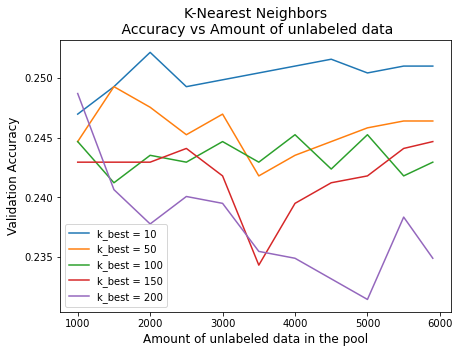

In [11]:
from sklearn.semi_supervised import SelfTrainingClassifier

Valid_Acc = []

for k_best in [10, 50, 100, 150, 200]:
    clf = KNeighborsClassifier(metric='cosine', n_neighbors=45)
    self_training_clf = SelfTrainingClassifier(clf, criterion='k_best', k_best=k_best)

    Y_train_salary_bin = train_df["salary_bin"].values.astype(int)
    # Unlabeled samples should have the label -1
    Y_train_salary_bin[8000:] = -1

    train_acc = []
    valid_acc = []

    for i in [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]:
        self_training_clf.fit(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i])
        train_acc.append(self_training_clf.score(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i]))
        valid_acc.append(self_training_clf.score(X_valid_combined_scaled, Y_valid_salary_bin))
        
    Valid_Acc.append(valid_acc)

figure(figsize=(7, 5))
x = [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]
x = [i - 8000 for i in x]

# Plot Validation accuracy
plt.plot(x, Valid_Acc[0], label = "k_best = 10")
plt.plot(x, Valid_Acc[1], label = "k_best = 50")
plt.plot(x, Valid_Acc[2], label = "k_best = 100")
plt.plot(x, Valid_Acc[3], label = "k_best = 150")
plt.plot(x, Valid_Acc[4], label = "k_best = 200")

plt.title('K-Nearest Neighbors\n Accuracy vs Amount of unlabeled data', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Amount of unlabeled data in the pool', fontsize=12)
plt.legend()
plt.show()

df = pd.DataFrame(columns = ['Amount of unlabeled data', 'k_best=10', 'k_best=50', 'k_best=100', 'k_best=150', 'k_best=200'])
df['Amount of unlabeled data'] = x
df['k_best=10'] = Valid_Acc[0]
df['k_best=50'] = Valid_Acc[1]
df['k_best=100'] = Valid_Acc[2]
df['k_best=150'] = Valid_Acc[3]
df['k_best=200'] = Valid_Acc[4]
df.to_excel('knn_k.xlsx')

In [12]:
df

,Amount of unlabeled data,k_best=10,k_best=50,k_best=100,k_best=150,k_best=200
0,1000,0.246978,0.244675,0.244675,0.242948,0.248705
1,1500,0.249280,0.249280,0.241220,0.242948,0.240645
2,2000,0.252159,0.247553,0.243523,0.242948,0.237766
3,2500,0.249280,0.245250,0.242948,0.244099,0.240069
4,3000,0.249856,0.246978,0.244675,0.241796,0.239493
5,3500,0.250432,0.241796,0.242948,0.234312,0.235463
6,4000,0.251007,0.243523,0.245250,0.239493,0.234888
7,4500,0.251583,0.244675,0.242372,0.241220,0.233161
8,5000,0.250432,0.245826,0.245250,0.241796,0.231434
9,5500,0.251007,0.246402,0.241796,0.244099,0.238342


#### Random Forest

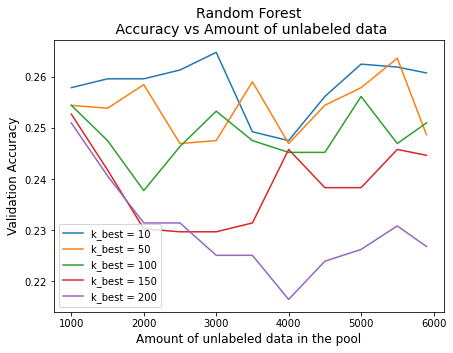

In [13]:
from sklearn.semi_supervised import SelfTrainingClassifier

Valid_Acc = []

for k_best in [10, 50, 100, 150, 200]:
    clf = RandomForestClassifier(criterion='entropy', max_depth=40, n_estimators=400)
    self_training_clf = SelfTrainingClassifier(clf, criterion='k_best', k_best=k_best)

    Y_train_salary_bin = train_df["salary_bin"].values.astype(int)
    # Unlabeled samples should have the label -1
    Y_train_salary_bin[8000:] = -1

    train_acc = []
    valid_acc = []

    for i in [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]:
        self_training_clf.fit(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i])
        train_acc.append(self_training_clf.score(X_train_combined_all_scaled[:i], Y_train_salary_bin[:i]))
        valid_acc.append(self_training_clf.score(X_valid_combined_scaled, Y_valid_salary_bin))

    Valid_Acc.append(valid_acc)

figure(figsize=(7, 5))
x = [9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 13902]
x = [i - 8000 for i in x]

# Plot Validation accuracy
plt.plot(x, Valid_Acc[0], label = "k_best = 10")
plt.plot(x, Valid_Acc[1], label = "k_best = 50")
plt.plot(x, Valid_Acc[2], label = "k_best = 100")
plt.plot(x, Valid_Acc[3], label = "k_best = 150")
plt.plot(x, Valid_Acc[4], label = "k_best = 200")

plt.title('Random Forest\n Accuracy vs Amount of unlabeled data', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Amount of unlabeled data in the pool', fontsize=12)
plt.legend()
plt.show()

df = pd.DataFrame(columns = ['Amount of unlabeled data', 'k_best=10', 'k_best=50', 'k_best=100', 'k_best=150', 'k_best=200'])
df['Amount of unlabeled data'] = x
df['k_best=10'] = Valid_Acc[0]
df['k_best=50'] = Valid_Acc[1]
df['k_best=100'] = Valid_Acc[2]
df['k_best=150'] = Valid_Acc[3]
df['k_best=200'] = Valid_Acc[4]
df.to_excel('rf_k.xlsx')

In [14]:
df

,Amount of unlabeled data,k_best=10,k_best=50,k_best=100,k_best=150,k_best=200
0,1000,0.257916,0.254462,0.254462,0.252735,0.251007
1,1500,0.259643,0.253886,0.247553,0.241796,0.240645
2,2000,0.259643,0.258492,0.237766,0.230282,0.231434
3,2500,0.261370,0.246978,0.246402,0.229706,0.231434
4,3000,0.264824,0.247553,0.253310,0.229706,0.225101
5,3500,0.249280,0.259067,0.247553,0.231434,0.225101
6,4000,0.247553,0.246978,0.245250,0.245826,0.216465
7,4500,0.256189,0.254462,0.245250,0.238342,0.223949
8,5000,0.262522,0.257916,0.256189,0.238342,0.226252
9,5500,0.261946,0.263673,0.246978,0.245826,0.230858
